In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Throat cancer dataset')
print('we are inside the folder',os.getcwd() )

we are inside the folder /content/drive/MyDrive/Throat cancer dataset


In [ ]:
data= '/content/drive/MyDrive/Throat cancer dataset'

In [ ]:
train_data= data + '//train'
os.listdir(train_data)

['OSCC', 'Normal']

No. of images in train folderwise

In [ ]:
print('No. of images in OSCC:', len(os.listdir(train_data + '//OSCC')))
print('No. of images in Normal:', len(os.listdir(train_data + '//Normal')))

No. of images in OSCC: 2476
No. of images in Normal: 2370


In [ ]:
test_path= data + "//test"
os.listdir(test_path)

['Normal', 'OSCC']

In [ ]:
print('No. of images in OSCC:', len(os.listdir(test_path + '//OSCC')))
print('No. of images in Normal:', len(os.listdir(test_path + '//Normal')))

No. of images in OSCC: 95
No. of images in Normal: 31


In [ ]:
import json
import math
import os
import cv2
import tensorflow
from PIL import Image
import numpy as np
from keras import layers

from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

In [ ]:
def dataset_load(dirct, RESIZE, sigmaX=10):
  IMG= []
  read= lambda imname: np.asarray(Image.open(imname).convert("RGB"))
  for IMAGE_NAME in tqdm(os.listdir(dirct)):
    PATH= os.path.join(dirct, IMAGE_NAME)
    _, ftype= os.path.splitext(PATH)
    if ftype == ".jpg":
      img= read(PATH)
      img = cv2.resize(img, (RESIZE, RESIZE))
      IMG.append(np.array(img))
  return IMG
  

In [ ]:
#Train
benign_train= np.array(dataset_load('train/Normal', 224))
malign_train= np.array(dataset_load('train/OSCC', 224))

#Test
benign_test= np.array(dataset_load('test/Normal', 224))
malign_test= np.array(dataset_load('test/OSCC', 224))

#Val
benign_val= np.array(dataset_load('val/Normal', 224))
malign_val= np.array(dataset_load('val/OSCC', 224))

100%|██████████| 92/92 [00:43<00:00,  2.11it/s]


In [ ]:
#Creating labels 
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))

benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

benign_val_label = np.zeros(len(benign_val))
malign_val_label = np.ones(len(malign_val))

In [ ]:
# Merge data 

X_train= np.concatenate((benign_train, malign_train), axis= 0)
Y_train= np.concatenate((benign_train_label, malign_train_label), axis= 0)

X_test= np.concatenate((benign_test, malign_test), axis=0)
Y_test= np.concatenate((benign_test_label, malign_test_label), axis=0)

X_val= np.concatenate((benign_val, malign_val), axis=0)
Y_val= np.concatenate((benign_val_label, malign_val_label), axis=0)



In [ ]:
#categorical 
Y_train= to_categorical(Y_train, num_classes=2)
Y_test= to_categorical(Y_test, num_classes=2)
Y_val= to_categorical(Y_val, num_classes=2)

In [ ]:
x_train=X_train
y_train=Y_train
x_val=X_val
y_val=Y_val

In [ ]:
BATCH_SIZE = 32

train_datagen = ImageDataGenerator( )

train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
val_generator = train_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE, shuffle= False)
test_generator = train_datagen.flow(X_test, Y_test, batch_size=BATCH_SIZE, shuffle= False)

In [ ]:
from tensorflow.keras.applications import EfficientNetB5

In [ ]:
model = EfficientNetB5(input_shape=(224,224,3), include_top= False, weights="imagenet")

115277824/115263384 [==============================] - 1s 0us/step


In [ ]:
#Turning off the traning layers

for layer in model.layers:
  layer.trainable= False

In [ ]:
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten

In [ ]:
custom_model= Sequential([
                          model,
                          GlobalAveragePooling2D(),
                          Dropout(0.5),
                          Flatten(),
                          BatchNormalization(),
                          Dense(512, activation='relu'),
                          BatchNormalization(),
                          Dropout(0.5),
                          Dense(1, activation='softmax')], name= "custom_model")

In [ ]:
custom_model.summary()

Model: "custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 7, 7, 2048)       28513527  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_2 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 512)              

In [ ]:
custom_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

In [ ]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoc, logs={}):
    if logs.get('accuracy')>0.99:
      print("\n Reached accuracy...Stopped Traning")
      self.model.stop_training= True

my_callback= MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback= ReduceLROnPlateau(moniter= "val_acc", patience=5, verbose=1, factor=0.2,min_lr=1e-4)


In [ ]:
CALLBACKS= [rop_callback, my_callback]

In [ ]:
step_epoch= x_train.shape[0] // BATCH_SIZE
print('Step epoch:', step_epoch)

Step epoch: 151


In [ ]:
history = custom_model.fit(
    train_generator,
    steps_per_epoch=step_epoch,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=CALLBACKS
)

Epoch 1/20
151/151 [==============================] - 43s 170ms/step - loss: 0.8148 - accuracy: 0.6564 - val_loss: 0.5635 - val_accuracy: 0.7250 - lr: 1.0000e-04
Epoch 2/20
151/151 [==============================] - 21s 141ms/step - loss: 0.6405 - accuracy: 0.7370 - val_loss: 0.4619 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 3/20
151/151 [==============================] - 21s 141ms/step - loss: 0.5688 - accuracy: 0.7727 - val_loss: 0.4291 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 4/20
151/151 [==============================] - 21s 141ms/step - loss: 0.5455 - accuracy: 0.7798 - val_loss: 0.3917 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 5/20
151/151 [==============================] - 21s 141ms/step - loss: 0.5262 - accuracy: 0.7923 - val_loss: 0.3871 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 6/20
151/151 [==============================] - 21s 141ms/step - loss: 0.4778 - accuracy: 0.8039 - val_loss: 0.3890 - val_accuracy: 0.8250 - lr: 1.0000e-04
Epoch 7/20
151/151 [========

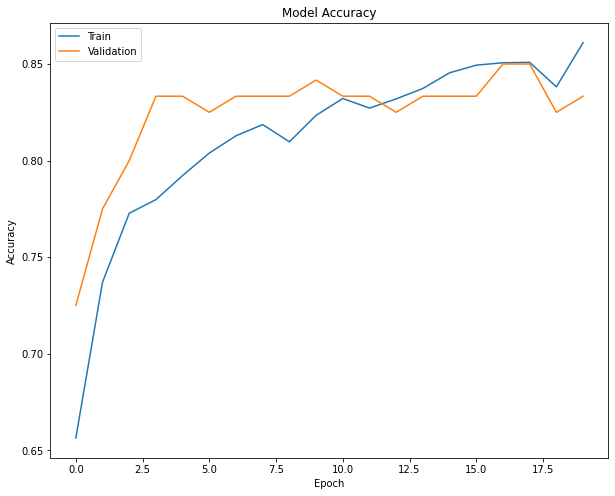

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [ ]:
#Evaluating the model on the data

test_scores = custom_model.evaluate(test_generator)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100), '\n')

train_scores = custom_model.evaluate(train_generator)
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100), '\n')

val_scores = custom_model.evaluate(val_generator)
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100),'\n')

4/4 [==============================] - 5s 226ms/step - loss: 0.4066 - accuracy: 0.8492
Testing Accuracy: 84.92% 

152/152 [==============================] - 20s 133ms/step - loss: 0.1691 - accuracy: 0.9408
Training Accuracy: 94.08% 

4/4 [==============================] - 1s 125ms/step - loss: 0.3431 - accuracy: 0.8333
Validation Accuracy: 83.33% 



In [ ]:
custom_model.save('Throat_efftnetB5_model.h5')

In [ ]:
# Load the  model
from keras.models import load_model
Loaded_model = load_model('/content/drive/MyDrive/Throat cancer dataset/Throat_resnet_model.h5')

In [ ]:
#Evaluating the model on the data

test_scores = Loaded_model.evaluate(test_generator)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100), '\n')

train_scores = Loaded_model.evaluate(train_generator)
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100), '\n')

val_scores = Loaded_model.evaluate(val_generator)
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100),'\n')

4/4 [==============================] - 1s 65ms/step - loss: 0.3234 - accuracy: 0.8571
Testing Accuracy: 85.71% 

152/152 [==============================] - 9s 62ms/step - loss: 0.1327 - accuracy: 0.9571
Training Accuracy: 95.71% 

4/4 [==============================] - 0s 60ms/step - loss: 0.3918 - accuracy: 0.8167
Validation Accuracy: 81.67% 

